In [366]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# 1. Data Preprocessing

In [367]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
df = pd.read_csv("../data/processed/filtered_essays.csv")
print(df.head())
print(df.info())

                                  Link  \
0  https://www.oalib.com/paper/3147510   
1  https://www.oalib.com/paper/3149804   
2  https://www.oalib.com/paper/2663751   
3  https://www.oalib.com/paper/5287715   
4  https://www.oalib.com/paper/5417852   

                                            Keywords  \
0  Child Care, Children, Adolescent, Mental Healt...   
1  Disabled Children, Mental Health Problems, Qua...   
2  Internet, Physical Health and Mental Health, C...   
3  Psychological Well-Being/Mental Health, “Left ...   
4  Street, Children, West Africa, Mental Health, ...   

                                            Abstract  
0  This study was carried out in order to investi...  
1  The aim of the study was to investigate the pr...  
2  The purpose of the research was to study the b...  
3  Background:In Asia, especially in China and AS...  
4  Background:Street life is a common sight among...  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data colum

In [369]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [370]:
df['Keywords'] = df['Keywords'].apply(lambda x: clean_text(str(x)))
df['Abstract'] = df['Abstract'].apply(lambda x: clean_text(str(x)))

In [371]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [372]:
def preprocess_text(text):
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

In [373]:
df['Keywords'] = df['Keywords'].apply(preprocess_text)
df['Abstract'] = df['Abstract'].apply(preprocess_text)

In [374]:
df.drop(columns = 'Link',inplace = True)

# 2. Data Exploration

For keywords analysis:

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [376]:
all_keywords = ' '.join(df['Keywords'].dropna()).split()

In [377]:
keyword_counts = Counter(all_keywords)

most_common_keywords = keyword_counts.most_common(30)
most_common_keywords

[('health', 41),
 ('mental', 35),
 ('child', 28),
 ('adolescent', 12),
 ('education', 5),
 ('obesity', 4),
 ('leftbehind', 4),
 ('physical', 3),
 ('parent', 3),
 ('depression', 3),
 ('intervention', 3),
 ('problem', 2),
 ('youth', 2),
 ('psychological', 2),
 ('victim', 2),
 ('promotion', 2),
 ('activity', 2),
 ('cognitive', 2),
 ('family', 2),
 ('changing', 2),
 ('service', 2),
 ('poverty', 2),
 ('school', 2),
 ('experience', 2),
 ('ill', 2),
 ('childrens', 2),
 ('research', 2),
 ('vitamin', 2),
 ('care', 1),
 ('nursing', 1)]

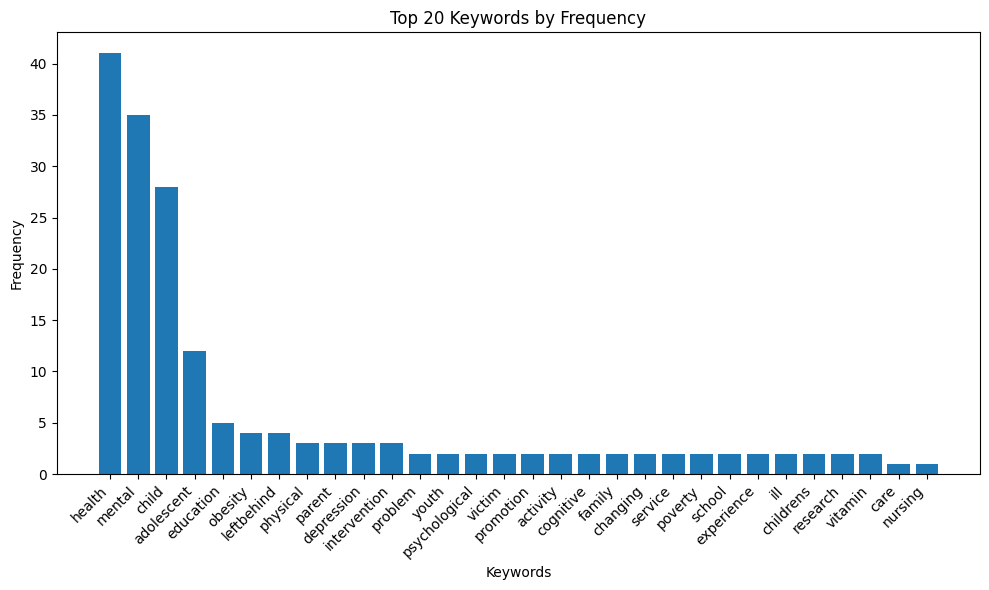

In [378]:
keywords, counts = zip(*most_common_keywords)
plt.figure(figsize=(10, 6))
plt.bar(keywords, counts)
plt.title("Top 20 Keywords by Frequency")
plt.xlabel("Keywords")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

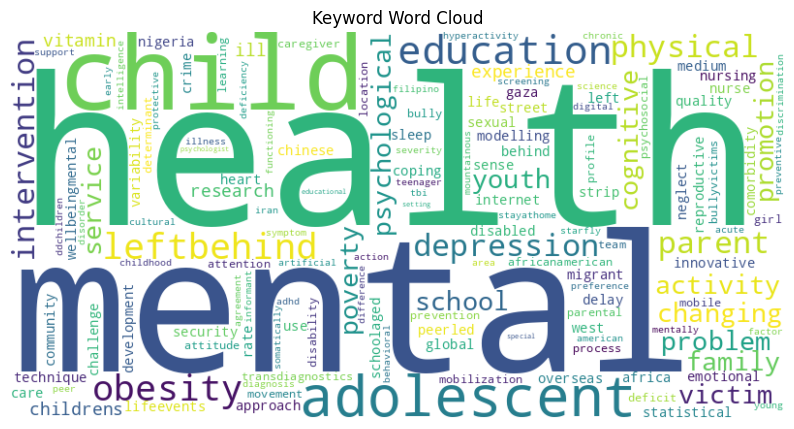

In [379]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(keyword_counts)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Keyword Word Cloud")
plt.show()

For abstract analysis:

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import gensim.downloader as api
from nltk.tokenize import word_tokenize
import string

In [ ]:
stop_words = set(stopwords.words("english"))
all_tokens = []

for abstract in df['Abstract'].dropna():
    abstract = abstract.lower()

    tokens = word_tokenize(abstract)
    tokens = [
        token for token in tokens
        if token.isalpha() and token not in stop_words and token not in string.punctuation and token.strip() != ""
    ]

    all_tokens.extend(tokens)


In [ ]:
# Load pre-trained word embeddings
word_vectors = api.load("glove-wiki-gigaword-50")

# Tokenize and normalize abstracts
all_tokens = []
for abstract in df['Abstract'].dropna():
    tokens = word_tokenize(abstract.lower())
    all_tokens.extend(tokens)

# Key terms for analysis
key_terms = ['internet','body', 'sleep', 'exercise','sex']

# Group similar terms using embeddings
similarity_threshold = 0.7
grouped_key_terms = {key_term: [] for key_term in key_terms}

for term in set(all_tokens):
    if term in word_vectors:
        for key_term in key_terms:
            if word_vectors.similarity(term, key_term) > similarity_threshold:
                grouped_key_terms[key_term].append(term)
                break

# Frequency analysis for grouped key terms
grouped_frequencies = {key_term: 0 for key_term in key_terms}
term_counts = Counter(all_tokens)

for key_term, terms in grouped_key_terms.items():
    for term in terms:
        grouped_frequencies[key_term] += term_counts.get(term, 0)
#Print grouped terms for each key term
print("Grouped Terms for Key Terms:")
for key_term, terms in grouped_key_terms.items():
    print(f"{key_term}: {', '.join(terms)}")



Grouped Terms for Key Terms:
internet: search, access, digital, mobile, provider, data, business, internet, information
body: human, head, taken, found, body
sleep: sleep, patient
exercise: routine, conduct, requires, exercise, action, effective, training, necessary
sex: sex, abuse, sexual, crime, discrimination, adult, behavior, child


In [383]:
grouped_key_terms["internet"].remove("business")

grouped_key_terms["body"].remove("found")
grouped_key_terms["body"].remove("taken")
grouped_key_terms["sleep"].remove("patient")


grouped_key_terms["exercise"].remove("requires")
grouped_key_terms["exercise"].remove("conduct")
grouped_key_terms["exercise"].remove("effective")
grouped_key_terms["exercise"].remove("necessary")


grouped_key_terms["sex"].remove("behavior")
grouped_key_terms["sex"].remove("adult")
grouped_key_terms["sex"].remove("child")
grouped_key_terms["sex"].remove("crime")
grouped_key_terms["sex"].remove("abuse")


In [384]:
grouped_key_terms["sleep"].extend(["insomnia"])

In [385]:
print("Grouped Terms for Key Terms:")
for key_term, terms in grouped_key_terms.items():
    print(f"{key_term}: {', '.join(terms)}")

Grouped Terms for Key Terms:
internet: search, access, digital, mobile, provider, data, internet, information
body: human, head, body
sleep: sleep, insomnia
exercise: routine, exercise, action, training
sex: sex, sexual, discrimination


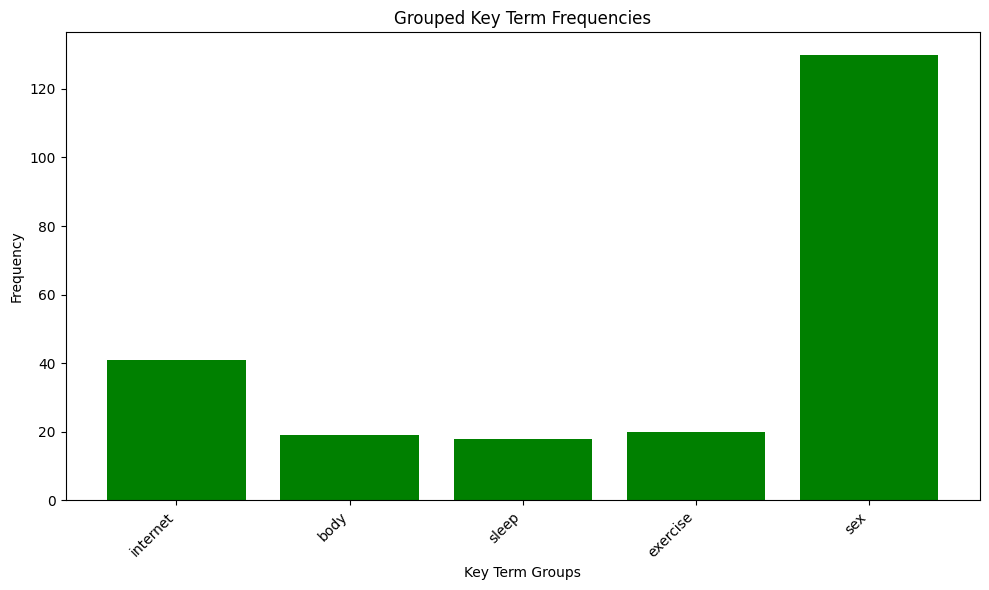

In [386]:
# Visualization: Word Frequency Bar Chart for Grouped Key Terms
plt.figure(figsize=(10, 6))
plt.bar(grouped_frequencies.keys(), grouped_frequencies.values(), color='green')
plt.title('Grouped Key Term Frequencies')
plt.xlabel('Key Term Groups')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# 3. Collocation Analysis

In [ ]:
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures

import spacy

In [388]:
# --- Collocation Analysis ---
bigram_finder = BigramCollocationFinder.from_words(all_tokens)
bigram_scores = bigram_finder.score_ngrams(BigramAssocMeasures.likelihood_ratio)

# Extract top 10 bigrams
top_bigrams = sorted(bigram_scores, key=lambda x: x[1], reverse=True)[:10]
print("Top 10 Collocations (Bigrams):")
for bigram, score in top_bigrams:
    print(f"{bigram}: {score}")


Top 10 Collocations (Bigrams):
('mental', 'health'): 590.798871609772
('physical', 'activity'): 90.4551568414237
('sense', 'security'): 76.27379708713335
('mobile', 'team'): 74.18090573356012
('life', 'event'): 62.43276405748617
('sexual', 'reproductive'): 57.80122088649254
('mobile', 'office'): 55.71204109286172
('statistically', 'significant'): 55.676682108475006
('symptom', 'severity'): 54.37310023237684
('rural', 'area'): 52.79772645244116


# 4. LDA model


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [414]:
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(df['Abstract'].dropna())

n_topics = 5
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(dtm)

print("LDA Topics with Key Terms:")
terms = vectorizer.get_feature_names_out()
for i, topic in enumerate(lda.components_):
    print(f"Topic {i+1}: {[terms[i] for i in topic.argsort()[-10:]]}")  # Top 10 terms per topic

df['dominant_topic'] = lda.transform(dtm).argmax(axis=1)
print("\nLinked Topics to Abstracts:")
print(df[['Abstract', 'dominant_topic']].head())

LDA Topics with Key Terms:
Topic 1: ['outcome', 'girl', 'adolescent', 'problem', 'diagnosis', 'intervention', 'group', 'child', 'mental', 'health']
Topic 2: ['discrimination', 'mental', 'impact', 'level', 'parental', 'sleep', 'association', 'study', 'problem', 'symptom']
Topic 3: ['functioning', 'mean', 'study', 'parent', 'childrens', 'adolescent', 'family', 'mental', 'child', 'health']
Topic 4: ['adolescent', 'parent', 'physical', 'effect', 'sleep', 'program', 'study', 'mental', 'health', 'child']
Topic 5: ['condition', 'disease', 'participant', 'intervention', 'sexual', 'issue', 'study', 'adolescent', 'mental', 'health']

Linked Topics to Abstracts:
                                            Abstract  dominant_topic
0  study carried order investigate professional f...               3
1  aim study investigate prevalence mental health...               2
2  purpose research study behavior child youth re...               3
3  backgroundin asia especially china aseanithas ...            

# 5. Pointwise Mutual Information (PMI):

In [ ]:
mental_health_terms = ["depression", "anxiety", "stress", "mental health", "distress", "suicide","illness","depressed","problem"]

bigram_finder = BigramCollocationFinder.from_words(all_tokens)

bigram_finder.apply_freq_filter(5)

pmi_scores = {}
for group, terms in grouped_key_terms.items():
    group_pmi = []
    for term in terms:
        for health_term in mental_health_terms:

            score = bigram_finder.score_ngram(BigramAssocMeasures.pmi, term, health_term)
            if score:
                group_pmi.append(score)

    avg_pmi = sum(group_pmi) / len(group_pmi) if group_pmi else 0
    pmi_scores[group] = avg_pmi

print("\nPointwise Mutual Information (PMI) Metrics:")
for group, avg_pmi in pmi_scores.items():
    print(f"Group '{group}': Average PMI = {avg_pmi:.2f}")




Pointwise Mutual Information (PMI) Metrics:
Group 'internet': Average PMI = 0.00
Group 'body': Average PMI = 0.00
Group 'sleep': Average PMI = 5.08
Group 'exercise': Average PMI = 0.00
Group 'sex': Average PMI = 0.00
